In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
num_of_data_point_i_want = 3000
data = pd.read_csv('train.csv',nrows=num_of_data_point_i_want, header=None)
#in total : 1710670 data point
res = data[8]
del res[0]

In [6]:
##get the float version of each trajectory
#initialize
trajectory = []
temp = []
final_res = []
test_res = []

for i in range(len(res)):
    #get the str version of each trajectory
    trajectory.append(res[i+1].split(',')) 
    
    
for i in range(len(trajectory)):
        # if the length of a trajectory is shorter than 1, means the trajectory doesn't exist
        if len(trajectory[i]) > 1 :
            for j in range(len(trajectory[i])):
                #remove unnecessary element 
                temp1 = trajectory[i][j].replace(']','')
                temp2 = temp1.replace('[','')
                trajectory[i][j] = float(temp2)

#delete all empty element
unwanted = []
for i in range(len(trajectory)):
    if trajectory[i] == ['[]']:
        unwanted.append(i)
trajectory = [j for i,j in enumerate(trajectory) if i not in unwanted]

longitude = [1]*(len(trajectory))
latitude = [1]*(len(trajectory))

#longitude and latitude for graph
for i in range(len(trajectory)):
    longitude[i] = trajectory[i][::2]
    latitude[i] = trajectory[i][1::2]

In [7]:
################
##有一位老人在porto画了一个圈
#change the variable bound_left,bound_right,bound_up,bound_down to limit the trajectories
#in latitude
bound_left = -8.692
bound_right = -8.535
#in longitude
bound_up = 41.2457
bound_down = 41.065

unwanted = []
#in fianl_res, each row means one trajectory
for i in range(len(trajectory)):
    for j in range(len(longitude[i])):
        ##if its not in the range
        
        if (longitude[i][j]>bound_right) or (longitude[i][j]<bound_left):
            unwanted.append(i)
            break
        elif (latitude[i][j]>bound_up) or (latitude[i][j]<bound_down):
            unwanted.append(i)
            break

#delete unwanted element from the list to get bounded longnitude and latitude
longitude_bound = [j for i,j in enumerate(longitude) if i not in unwanted]
latitude_bound = [j for i,j in enumerate(latitude) if i not in unwanted]

## AND refresh the final_res list to be:
final_res_new = [j for i,j in enumerate(trajectory) if i not in unwanted]
# len(longitude_bound)
# len(latitude_bound)


In [9]:
## modify num_grid_row and num_grid_col to change the grid numbers
num_grid_row = 20
num_grid_col = 20

#get the length of each grid
len_grid_row = (bound_right - bound_left)/num_grid_row
len_grid_col = (bound_up - bound_down)/num_grid_col

#change every geographic point into a specific grid number
row_index = []
col_index = []
row_index_temp1 = []
col_index_temp1 = []
for i in range(len(final_res_new)):
    
    for j in range(len(latitude_bound[i])):
        row_index_temp = int((longitude_bound[i][j] - bound_left)//len_grid_row)
        col_index_temp = int((latitude_bound[i][j] - bound_down)//len_grid_col)
        row_index_temp1.append(row_index_temp)
        col_index_temp1.append(col_index_temp)
    row_index.append(row_index_temp1)
    col_index.append(col_index_temp1)
    row_index_temp1 = []
    col_index_temp1 = []

In [10]:
###find the length of the trajectories
len_size = 80
index_len = np.zeros(len_size)
temp = 0 
for i in range(len(row_index)):
    if  (len(row_index[i])<len_size):
        index_len[len(row_index[i])]+=1
        temp += 1
for i in range(80):
    index_len[i] = index_len[i]/temp

#index_len

# Predictors

### 1.P(E|S)

In [12]:
###get the start and end point for each trajectory

#initialize
start_row = []
start_col = []
end_row = []
end_col = []
#find start and end point
for i in range(len(row_index)):
    start_row.append(row_index[i][0])
    start_col.append(col_index[i][0])
    end_row.append(row_index[i][-1])
    end_col.append(col_index[i][-1])
    
#输入一个start_point, 输出一个 dictionary，这个dictionary 的每一个key是possible end_point 然后对应的概率

def PES(start_point_row,start_point_col):
    dic = {}
    for i in range(len(start_row)):
        #如果对应的end point 已经存在，那么dict[this spcific start_point] += 1;
        #如果对应的end point 还没有记录过，那么dict[this specific start_point] = 1;
            
        if (start_row[i] == start_point_row) and (start_col[i] == start_point_col):
            end = (end_row[i],end_row[i])
            if end in dic:
                dic[end] += 1
            else:
                dic[end] = 1
##transfer count into probability
    total = 0
    for k in dic:
        total += dic[k]
    for k in dic:
        dic[k] = dic[k]/total    
    return dic

#####
##THIS code may be extremely slow and need modify

### 2.P(E|C)

In [13]:
def PEC(start_point_row,start_point_col):
    dic = {}
    #for every trajectory
    for i in range(len(row_index)):
        #for every point in the trajectory
        for j in range(len(row_index[i])-1):
            if(row_index[i][j] == start_point_row) and (col_index[i][j] == start_point_col):
                end = (row_index[i][len(row_index[i])-1], col_index[i][len(col_index[i])-1])
                if end in dic:
                    dic[end] += 1
                else: 
                    dic[end] = 1
    total = 0
    for k in dic:
        total+=dic[k]
    for k in dic:
        dic[k] = dic[k]/total
    return dic

### 3.First_order Markov Model

In [16]:
from copy import copy, deepcopy
row_with_finish = deepcopy(row_index)
col_with_finish = deepcopy(col_index)
for i in range(len(longitude_bound)):
    row_with_finish[i].append('TRUE')
    col_with_finish[i].append('TRUE')

def adjacent_point(start_point_row,start_point_col,direction):
    if (direction == 0):
        next_state = (start_point_row,start_point_col)
    elif (direction == 1):
        next_state = (start_point_row+1,start_point_col)
    elif (direction == 2):
        next_state = (start_point_row-1,start_point_col)
    elif (direction == 3):
        next_state = (start_point_row,start_point_col-1)
    elif (direction == 4):
        next_state = (start_point_row,start_point_col+1)
    elif (direction == 5):
        next_state = (start_point_row+1,start_point_col-1)
    elif (direction == 6):
        next_state = (start_point_row+1,start_point_col+1)
    elif (direction == 7):
        next_state = (start_point_row-1,start_point_col-1)
    elif (direction == 8):
        next_state = (start_point_row-1,start_point_col+1)
    else:
        next_state = ('TRUE','TRUE')
    return next_state

In [22]:
epsilon = 0.1
def first_markov(start_point_row,start_point_col):
    dic = {}
    # for every trajectory    
    for i in range(len(row_with_finish)):
        #for every point during the trip
        for j in range(len(row_with_finish[i])-1):
            if (row_with_finish[i][j]==start_point_row) and (col_with_finish[i][j]==start_point_col):
                next_state = (row_with_finish[i][j+1],col_with_finish[i][j+1])
                if next_state in dic:
                    dic[next_state] += 1
                else:
                    dic[next_state] = 1
    for i in range(9):
        next_state = adjacent_point(start_point_row,start_point_col,i)
        #print(next_state)
        a = next_state[0]
        #print('a = ',a)
        b = next_state[1]
        #print('b = ',b)

        #print('num_grid_col = ',num_grid_col )
        #print(a<=num_grid_col)
        
        
        if(a>=0) and (a<num_grid_col) and (b>=0) and (b<num_grid_row):
            if next_state in dic:
                
                dic[next_state] += epsilon
            else:
                dic[next_state] = epsilon
    
    ##transfer count into probability
    total = 0
    for k in dic:
        total += dic[k]
    for k in dic:
        dic[k] = dic[k]/total
    
    return dic



## Visualization of the next step 

In [91]:
def adjacent_point(start_point_row,start_point_col,direction):
    if (direction == 0):
        next_state = (start_point_row,start_point_col)
    elif (direction == 1):
        next_state = (start_point_row-1,start_point_col-1)
    elif (direction == 2):
        next_state = (start_point_row,start_point_col-1)
    elif (direction == 3):
        next_state = (start_point_row+1,start_point_col-1)
    elif (direction == 4):
        next_state = (start_point_row-1,start_point_col)
    elif (direction == 5):
        next_state = (start_point_row+1,start_point_col)
    elif (direction == 6):
        next_state = (start_point_row-1,start_point_col+1)
    elif (direction == 7):
        next_state = (start_point_row,start_point_col+1)
    elif (direction == 8):
        next_state = (start_point_row+1,start_point_col+1)
    return next_state

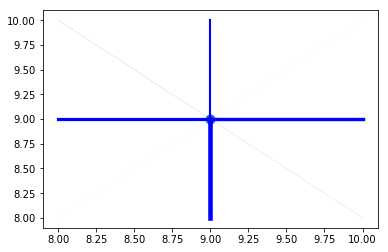

In [100]:
current_state = (9,9)
a = current_state[0]
b = current_state[1]
next_state = first_markov(a,b)

line_width = np.zeros(9)
# 0 : mid
# 1 : top-left
# 2 : top
# 3 : top-right
# 4 : left
# 5 : right
# 6 : bot-left
# 7 : bot
# 8 : bot-right

if(current_state in next_state):
    line_width[0]+=next_state[current_state]
if((a-1,b-1) in next_state):
    line_width[1]+= next_state[(a-1,b-1)]
if((a,b-1) in next_state):
    line_width[2]+= next_state[(a,b-1)]
if((a+1,b-1) in next_state):
    line_width[3]+= next_state[(a+1,b-1)]
if((a-1,b) in next_state):
    line_width[4]+= next_state[(a-1,b)]
if((a+1,b) in next_state):
    line_width[5]+= next_state[(a+1,b)]
if((a-1,b+1) in next_state):
    line_width[6]+= next_state[(a-1,b+1)]
if((a,b+1) in next_state):
    line_width[7]+= next_state[(a,b+1)]
if((a+1,b+1) in next_state):
    line_width[8]+= next_state[(a+1,b+1)]
    

for i in range(9):
    temp = adjacent_point(a,b,i)
    x_next = temp[0]
    y_next = temp[1]
    x = [a,x_next]
    y = [b,y_next]
    if(x_next != x and y_next != y):
        plt.plot(x,y,c='b',linewidth = line_width[i]*100)
plt.scatter(a,b,s = line_width[0]*100)

plt.show()

# Evaluation